we didn't really do uch and our code is giving us bugs and we weren't really comfortable with using classes and we are not familiar with this k
Aleena Sibi, Kriti Baweja

# Two-body bound state problem

The aim of this notebook is to solve the two spin-less boson bound state problem in momentum space in its discretized form:
\begin{equation}
\psi_l(p_i) = \frac{1}{E-\frac{p_i^2}{2\mu_{12}}} \sum_j w_j \, p_j^2 V_l(p_i,p_j) \ \psi_l(p_j) \  .
\end{equation}


## Define a two-body interaction

I will work with a class that provides a method for the partial wave projection $V(p,p',l)$ of a bosonic 
interaction.   

A realistic test case is given by a OBE exchange interaction 
$$ V(\vec p, \vec p') = \frac{A}{2\pi} \frac{1}{(\vec p - \vec p')^2 + m_B^2} \exp\left(-\frac{(\vec p - \vec p')^2 + m_B^2}{\Lambda^2 }\right) + \frac{C_0}{4 \pi } \exp\left( - \frac{p^2+{p'}^2}{\Lambda^2}\right) $$ 


In [2]:
# for simplicity, we define the OBE exchange by numerical integration 
# and add one contact term to be determined using either a bound state or a scattering length 

import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre


class OBEpot:
    """Provides a method for the partial wave representation of the OBE potential. 
    
       The matrix elements are obtained by numerical intergration.
       The mass of the exchanged boson, the strength of the 
       interaction and the couter term is given on initialization. 
       The interaction is regularized using a cutoff that is also 
       given on init.
    """
    
    # this are common parameters for all instances 
    hbarc=197.327
    
    # init interaction
    def __init__(self, cutoff=500.0, C0=1.0, nx=12,mpi=138.0,A=-1.0):
        """Defines the one boson exchange for a given regulator, coupling strength and short distance parameter
        
        Parameters:
        cutoff -- regulator in MeV
        C0 -- strength of the short distance counter term (in s-wave) 
        A -- strength of OBE
        nx -- number of angular grid points for numerical integration
        mpi -- mass of exchange boson in MeV"""
        
        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.A=A
        self.nx=nx
        
        self.xp=np.empty((self.nx),dtype=np.double)
        self.xw=np.empty((self.nx),dtype=np.double)
        self.xp,self.xw=leggauss(self.nx)
    
    
    
    # function defines the x integral 
    def _g(self,pp,p,k):
        """Calculates g function of the partial wave decomposition of OBE. 
        
           pp -- outgoing momentum 
           p -- incoming momentum
           k -- angular momentum"""
        
        # define prefact 
        # get the corresponding legendre polynomial 
        Pk = legendre(k)
        # define momentum transfer dependent on angles 
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)
        
        # build integral of regularized OBE 
        return float(np.sum(Pk(self.xp)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2)))
        
    # determines complete, regularized interaction     
    def v(self,pp,p,l):
        """Potential matrix element in fm**2
        
           pp -- outgoing momentum in fm**-1
           p -- incoming momentum in fm**-1
           l -- angular momentum""" 
        
        # first overall prefact of 1pi exchange part  (cancel 2pi factors!)
        prefact=self.A
        
        mat=prefact*self._g(pp,p,l)

        if (l==0):   # add s-wave counter term 
          mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)  # 4pi is take into account by spherical harmonics for l=0
                    
        return mat



## Solution of the two-body bound state problem

In [3]:
import numpy as np 
from numpy.polynomial.legendre import leggauss
from scipy.special import spherical_jn
from scipy.interpolate import interp1d
import timeit

class TwoBody:
    """Methods to obtain eigenvalues and eigenvectors for the bound state problem and for searches of the binding energy."""
    # define hbarc for unit conversion 
    hbarc=197.327  
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, mred=938.92/2,l=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=200,np2four=100):
        """Initialization of two-body solver. 
        
           The initialization defines the momentum grids and the interaction and partial wave to be used. 
           At this time, also the grid for Fourier transformation and for the Fourier transformed 
           wave function is given. 
           
           Parameters:
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of grid points in interval [0,pb] 
           np2 -- number of grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           mred -- reduces mass of the two bosons in MeV
           
           nr1 -- number of r points in interval [0,rb] 
           nr2 -- number of r points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,pa]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p points in interval [0,pb] for Fourier trafo
           np2four -- number of p points in interval [pb,pc] for Fourier trafo"""
        
        # measure also time for preparation (mostly from potential)
        self.preptime=-timeit.default_timer() 

        # store parameters (if necessary convert to fm)
        self.np1 = np1
        self.np2 = np2
        self.npoints  = np1+np2 
        self.mred=mred/self.hbarc
        self.pa=pa
        self.pb=pb
        self.pc=pc
        self.l=l 

        self.nr1 = nr1
        self.nr2 = nr2
        self.nrpoints  = nr1+nr2 
        self.ra=ra
        self.rb=rb
        self.rc=rc

        self.np1four = np1four
        self.np2four = np2four
        self.npfour  = np1four+np2four 

        # store grid points and weights for integral equations
        self.pgrid,self.pweight = self._trns(self.np1,self.np2,self.pa,self.pb,self.pc)
 
        # store grid points and weights for r space wave fudnctions
        self.rgrid,self.rweight = self._trns(self.nr1,self.nr2,self.ra,self.rb,self.rc)
        
        # store grid points and weights for Fourier trafo 
        self.pfourgrid,self.pfourweight = self._trns(self.np1four,self.np2four,self.pa,self.pb,self.pc)
        
        # store underlying interaction
        self.pot=pot
        
        # and actual potential matrix elements 
        self.vmat=np.empty((self.npoints,self.npoints),dtype=np.double)
        for i in range(self.npoints):
          for j in range(self.npoints): 
            self.vmat[i,j]=self.pot.v(self.pgrid[i],self.pgrid[j],self.l)

        self.preptime+=timeit.default_timer() 
    
        print("Preparatione time: {0:15.6e} sec".format(self.preptime))
            
        # fix timer for solution of the eigenvalue equations
        self.runtime=0.0
        
    def _trns(self,np1,np2,pa,pb,pc):
      """Auxilliary method that provides transformed Gauss-Legendre grid points and integration weights.
      
         This is using a hyperbolic trafo shown in the lecture. 
         Parameter: 
         np1 --  grid points in ]0,pb[
         np2 --  grid points are distributed in ]pb,pc[ using a linear trafo
         
         pa  -- half of np1 points are in interval [0,pa]
         pb  -- interval boundary as defined above 
         pc  -- upper integration boundary """ 
    
      x1grid,x1weight=leggauss(np1)
      x2grid,x2weight=leggauss(np2)

      # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval 
      p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
      p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

      # linear trafo 
      p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
      p2weight=(pc-pb)/2.0*x2weight
   
      pgrid=np.empty((self.npoints),dtype=np.double)
      pweight=np.empty((self.npoints),dtype=np.double)
    
      pgrid = np.concatenate((p1grid, p2grid), axis=None)
      pweight = np.concatenate((p1weight, p2weight), axis=None)
   
      return pgrid,pweight 

# set up set of equations and calculate eigenvalues 

    def eigv(self,E,neigv):
      """Solve two-body integral equation and return n-th eigenvalue, momentum grid and wave function. 

         Parameters:
         E -- energy used in the integral equation in fm**-1 
         neigv -- number of the eigenvalue to be used"""
   
    # measure timeing (compare for loop and einsum)
      self.runtime-=timeit.default_timer() 
    
    # set up the matrix amat for which eigenvalues have to be calculated
    
      amat=np.einsum('i,ij,j->ij', 1.0/(E-self.pgrid**2/(2*self.mred)),self.vmat,self.pweight*self.pgrid**2)   
      # replaces less performant for loops   
      #amat=np.empty((self.npoints,self.npoints),dtype=np.double)
      #for i in range(self.npoints):
      #  for j in range(self.npoints): 
      #    amat[i,j]=np.real(1.0/(E-self.pgrid[i]**2/(2*self.mred))*self.vmat[i,j]*self.pweight[j]*self.pgrid[j]**2)

    # determine eigenvalues using numpy's eig method        
      evalue,evec=np.linalg.eig(amat)
    
    # I now assume that the relevant eigenvalues are real to avoid complex arithmetic 
      evalue=np.real(evalue)
        
    # remove neigv-1 largest eigenvalues 
      for n in range(neigv-1):
        maxpos=np.argmax(evalue)
        evalue[maxpos]=0.0
    
    # take the next one 
      maxpos=np.argmax(evalue)
      eigv=evalue[maxpos]
    # define solution as unnormalized wave function 
      wf=evec[:,maxpos]
    # and normalize 
      norm=np.sum(wf**2*self.pweight[0:self.npoints]*self.pgrid[0:self.npoints]**2)
      wf=1/np.sqrt(norm)*wf
    
    # measure timeing (compare for loop and einsum)
      self.runtime+=timeit.default_timer()
    
      return eigv,self.pgrid[0:self.npoints],wf

    
    def esearch(self,neigv=1,e1=-0.01,e2=-0.0105,elow=0.0,tol=1e-8):
        """Perform search for energy using the secant method. 
        
           Parameters:
           neigv -- number of the eigenvalue to be used
           e1 -- first estimate of binding energy (should be negative)
           e2 -- second estimate of binding energy (should be negative)
           elow -- largest energy to be used in search (should be negative)
           tol -- if two consecutive energies differ by less then tol, the search is converged
           
           Energies are given in fm**-1. """
        
        # determine eigenvalues for starting energies        
        eta1,pgrid,wf=self.eigv(e1,neigv)
        eta2,pgrid,wf=self.eigv(e2,neigv)
        
        while abs(e1-e2) > tol: 
          # get new estimate (taking upper value into account)   
          enew=e2+(e1-e2)/(eta1-eta2)*(1-eta2) 
          enew=min(elow,enew)
       
          # get new eigenvalue and replace e1 and e2 for next iteration
          eta,pgrid,wf=self.eigv(enew,neigv)
          e2=e1
          eta2=eta1
          e1=enew
          eta1=eta 
                
        print("Total runtime: {0:15.6e} sec".format(self.runtime))  
  
        return e1,eta1,pgrid,wf 
           
    def fourier(self,wfp):
        """Calculates the Fourier transform of the partial wave representation of the wave function.
        
           Parameter: 
           wfp -- wave function in momentum space
            
           Note that the factor I**l is omitted."""
        
        # calculate spherical bessel functions based dense Fourier trafo momentum grid and rgrid
        # prepare matrix based on r,p points  
        rpmat = np.outer(self.rgrid,self.pfourgrid)
        # evaluate jl     
        jlmat = spherical_jn(self.l,rpmat)
        
        # interpolate of wave to denser Fourier trafo grid
        wfinter = interp1d(self.pgrid, wfp, kind='cubic',fill_value="extrapolate")
        # interpolate wf and multiply my p**2*w elementwise 
        wfdense = wfinter(self.pfourgrid)*self.pfourgrid**2*self.pfourweight*np.sqrt(2/m.pi)
        
        # now the Fourier trafo is a matrix-vector multiplication 
        wfr = jlmat.dot(wfdense)
        
        return self.rgrid,wfr
    
    
    def rms(self,wfr):
        """Calculates the norm and rms radius for the given r-space wave function.
        
           Normalization of the wave function is assumed. 
           Parameter: 
           wfr -- wave function in r-space obtained by previous Fourier trafo"""
        
        
        norm=np.sum(wfr**2*self.rweight*self.rgrid**2)
        rms=np.sum(wfr**2*self.rweight*self.rgrid**4)

            
        rms=np.sqrt(rms)
        
        return norm,rms
    
    
        

In [43]:
import numpy as np
# prepare interpolation using cubic hermitian splines 

class Cubherm:
    """Prepares spline functions for cubic hermitian splines. 
    
    see Hueber et al. FBS 22,107 (1997). 
    
    The function spl returns the the spline function for a given x. 
    If x is below the smallest grid point, extrapolation is used. 
    If x is after largest grid point, then the function evaluates to zero. 
    """
    
        
    def spl(xold,xin):
        """Calculates spline functions for given values xold and xnew.
        
           Parameters:
           xold -- set of grid points where function is given. xold needs to be one dimensional.
           xnew -- set of grid points to interpolate to. xnew can be multidimensional. 
           
           On return spline functions will be given that have the shape of xnew and xold combined. 
        """
        
        # first determine the base value of the index for each xnew.
        
        nold=len(xold)
        if nold<4:
          raise(ValueError("Interpolation requires at least 4 grid points.")) 
        
        xnew=xin.reshape((-1))        
        indx=np.empty((len(xnew)),dtype=np.int)
        
        for i in range(len(xnew)):
          # do not extrapolated beyond largest grid point
          if xnew[i] > xold[nold-1]: 
            indx[i]=-1
          else:  
            for j in range(nold):
              if xnew[i] <= xold[j]:
                break          
            if j < 1:
              indx[i]=0
            elif j > nold-3:
              indx[i]=nold-3
            else:
              inddx[i]=j-1  

        # then prepare phi polynomials for each x 
        
        phi1=np.zeros((len(xnew)),dtype=np.double)
        phi2=np.zeros((len(xnew)),dtype=np.double)
        phi3=np.zeros((len(xnew)),dtype=np.double)
        phi4=np.zeros((len(xnew)),dtype=np.double)
        
        for i in range(len(xnew)):
          if indx[i]>0:  
            phi1[i] = (xold[indx[i] + 1] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 3 * (xold[indx[i] + 1] - 3 * xold[indx[i]] + 2 * xnew[i])
            phi2[i] = (xold[indx[i]] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 3 * (3 * xold[indx[i] + 1] - xold[indx[i]] - 2 * xnew[i])
            phi3[i] = (xnew[i] - xold[indx[i]]) * (xold[indx[i] + 1] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 2
            phi4[i] = (xnew[i] - xold[indx[i] + 1]) * (xold[indx[i]] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 2
        
        # now we are ready to prepare the spline functions 
        # most are zero 
        splfu=np.zeros((len(xold),len(xnew)),dtype=np.double)
        for i in range(len(xnew)):
          if indx[i]>0:  
            splfu[indx[i]-1,i] = \
               -phi3[i]*(xold[indx[i]+1]-xold[indx[i]])/(
                        (xold[indx[i]]-xold[indx[i]-1])*(xold[indx[i]+1]-xold[indx[i]-1]))
            
            splfu[indx[i],i] = phi1[i] \
                +phi3[i]*((xold[indx[i]+1]-xold[indx[i]])/ (xold[indx[i]]-xold[indx[i]-1]) \
                         -(xold[indx[i]]-xold[indx[i]-1])/ (xold[indx[i]+1]-xold[indx[i]]))/(xold[indx[i]+1]-xold[indx[i]-1]) \
                -phi4[i]*(xold[indx[i]+2]-xold[indx[i]+1])/ (xold[indx[i]+1]-xold[indx[i]])/(xold[indx[i]+2]-xold[indx[i]])

            splfu[indx[i]+1,i] = phi2[i] \
                +phi3[i]*(xold[indx[i]]-xold[indx[i]-1])/ (xold[indx[i]+1]-xold[indx[i]])/(xold[indx[i]+1]-xold[indx[i]-1]) \
                +phi4[i]*((xold[indx[i]+2]-xold[indx[i]+1])/ (xold[indx[i]+1]-xold[indx[i]]) \
                         -(xold[indx[i]+1]-xold[indx[i]])/ (xold[indx[i]+2]-xold[indx[i]+1]))/(xold[indx[i]+2]-xold[indx[i]])
            
            
            splfu[indx[i]+2,i] = \
                phi4[i]*(xold[indx[i]+1]-xold[indx[i]])/(
                        (xold[indx[i]+2]-xold[indx[i]+1])*(xold[indx[i]+2]-xold[indx[i]]))
          elif indx[i]>=0:
            # do linear interpolation at the origin 
            splfu[indx[i],i] = (xnew[i]-xold[indx[i]+1])/(xold[indx[i]]-xold[indx[i]+1]) 
            splfu[indx[i]+1,i] = (xold[indx[i]]-xnew[i])/(xold[indx[i]]-xold[indx[i]+1]) 

        retshape=[nold] 
        for n in list(np.shape(xin)):
          retshape.append(n)
        
        return splfu.reshape(retshape)
    

In [46]:
def trns(np1,np2,pa,pb,pc):
 

    x1grid,x1weight=leggauss(np1)
    x2grid,x2weight=leggauss(np2)

    npoints = np1 + np2

    # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval 
    p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
    p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

    # linear trafo 
    p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
    p2weight=(pc-pb)/2.0*x2weight

    pgrid=np.empty((npoints),dtype=np.double)
    pweight=np.empty((npoints),dtype=np.double)

    pgrid = np.concatenate((p1grid, p2grid), axis=None)
    pweight = np.concatenate((p1weight, p2weight), axis=None)

    return pgrid,pweight 

The following cell is just for testing the interpolation routines. 

Preparatione time:    8.096981e-01 sec
Total runtime:    1.765990e-02 sec


KeyboardInterrupt: 

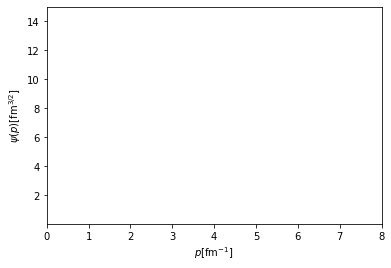

In [47]:
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm

# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$p$[fm$^{-1}$]')
ax.set_ylabel(r'$\psi(p)$[fm$^{3/2}$]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

ax.set_xlim(0,8)
ax.set_ylim(1E-6,15)


# fit result copied from above 
res=[[300.0, -0.09827953494014054],
 [400.0, -0.028203145146196713],
 [500.0, -0.0004221894040945335],
 [600.0, 0.012857431330421717],
 [700.0, 0.020167185806378923],
 [800.0, 0.024707945457255083],
 [900.0, 0.027865200396659445],
 [1000.0, 0.030308007813785776],
 [1100.0, 0.03239034331482156],
 [1200.0, 0.03431611357447293]]

# go through parameters of fit
q = np.linspace(0,10,10)
Farr = []
for para in res:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    solver=TwoBody(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    # perform energy search for this parameter set
    ener,lam,pmom,wf=solver.esearch(neigv=1,e1=-2.0/TwoBody.hbarc,e2=-2.5/TwoBody.hbarc)
    
    thetaarr,thweight=leggauss(len(pmom))
   
    for k in range(10):
        pnew=np.zeros([len(thetaarr),len(pmom)])
        for j in range(len(thetaarr)):
            pnew[j,:]=(pmom**2+q[k]**2/4-2*pmom*q[k]*thetaarr[j])
            
#         print(Cubherm.spl(pmom, pnew).shape)

        wfnew=np.sum([wf[i]*Cubherm.spl(pmom,pnew)[i,:,:] for i in range(len(pmom))], axis=0)
        print(wfnew)
        Ylm = sph_harm(1, 1, np.arccos(thetaarr), 0)
        Ylm_q = sph_harm(1,1,np.arccos((pmom*thetaarr - q[k]/2)/(np.linalg.norm(pnew,axis=0))),0)

        #x1grid,x1weight=leggauss(len(pmom))
        #norm=np.sum(wfr**2*self.rweight*self.rgrid**2)

        Ang =np.sum(Ylm*Ylm_q*wfnew*wf*thweight)
        pgrid,pweight = trns(40,20,1.0,7.0,35.0)
        F = np.sum(pweight*Ang*pgrid**2)
        print(F)
        Farr.append(F)
    
    
    
    # get Fourier trafo (together with r grid points)
    rp,wfr=solver.fourier(wf)
    # calculate norm and rms radius (deviation of the norm from 1 gives idea of accuracy)
    norm,rms=solver.rms(wfr)
    
    # plot the wave function in momentum space (here use log scale and abs values, if statement takes care 
    # of the sign of wf when a linear scale and no abs values is used)
    if wf[0]>0:
      ax.semilogy(pmom,np.abs(wf),label=r"$\Lambda=$ {0:10.3f}".format(para[0]))
    else:  
      ax.semilogy(pmom,np.abs(-wf),label=r"$\Lambda=$ {0:10.3f}".format(para[0]))   # this part is only relevant for a non log plot

    
    # print energy, eigenvalue (should be one), norm and 1/2 rms (= radius to the CM for equal mass particles)
    print("{0:15.6e}   {1:15.6e}  {2:15.6e}   {3:15.6e}".format(ener*TwoBody.hbarc,lam, norm, rms/2.0)) #rms is printed for distance to CM assuming equal masses

ax.legend(loc="best")
    
plt.show()    

Radii agree within numerical accuracy (e.g. for $\Lambda=1200$ MeV compare to $2.070864$.

ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

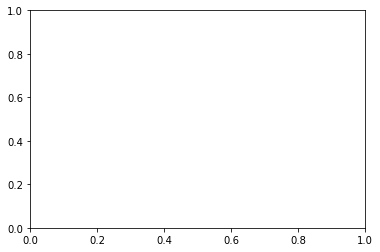

In [30]:
plt.plot(q,Farr)

In [42]:
wf

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [40]:
pnew=np.zeros([len(thetaarr),len(pmom)])
for j in range(len(thetaarr)):
    pnew[j,:]=(pmom**2+q[k]**2/4-2*pmom*q[k]*thetaarr[j])

#         print(Cubherm.spl(pmom, pnew).shape)

wfnew=np.sum([wf[i]*Cubherm.spl(pmom,pnew)[i,:,:] for i in range(len(pmom))], axis=0)
print(wfnew)
Ylm = sph_harm(1, 1, np.arccos(thetaarr), 0)
Ylm_q = sph_harm(1,1,np.arccos((pmom*thetaarr - q[k]/2)/(np.linalg.norm(pnew,axis=0))),0)

#x1grid,x1weight=leggauss(len(pmom))
#norm=np.sum(wfr**2*self.rweight*self.rgrid**2)

Ang =np.sum(Ylm*Ylm_q*wfnew*wf*thweight)
pgrid,pweight = trns(40,20,1.0,7.0,35.0)
F = np.sum(pweight*Ang*pgrid**2)
print(F)
Farr.append(F)


[[-0.18400377+0.j -0.17449671+0.j -0.15895896+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.18401155+0.j -0.1745347 +0.j -0.15904137+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.18402552+0.j -0.17460298+0.j -0.15918955+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [-0.18868259+0.j -0.19920304+0.j -0.21916919+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.1886971 +0.j -0.19928442+0.j -0.21938287+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.18870517+0.j -0.19932973+0.j -0.2195019 +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]]
0j
